In [4]:
import logging
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

from tqdm import tqdm

from automltsad.detectors.callbacks import (
    RichProgressBar, ModelCheckpoint, EarlyStopping, LearningRateFinder)
from automltsad.detectors import LSTM_AE_Det
from automltsad.transform import MeanVarianceScaler
from automltsad.utils import (
    sliding_window_sequences, reduce_window_scores, 
    to_time_series, to_time_series_dataset)
from automltsad.metrics import (
    average_precision_score, roc_auc_score, f1_pa, f1_pa_auc_score, 
    f1_pa_curve, mass_volume_curve, mass_volume_auc_score, 
    mv_feature_subsampling_auc_score, excess_mass_curve, 
    excess_mass_auc_score, em_feature_subsampling_auc_score, 
    PrecisionRecallDisplay, RocCurveDisplay, precision_recall_curve)


warnings.filterwarnings('ignore')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

FILE_ID = 3
print(sorted(os.listdir('./data/datasets'))[FILE_ID])
file = sorted(os.listdir('./data/datasets'))[FILE_ID]

test_start, anomaly_start, anomaly_end = [
    int(i) for i in file.split('.')[0].split('_')[-3:]
]

a = np.loadtxt(f'./data/datasets/{file}')
a = to_time_series_dataset(a)
slr = MeanVarianceScaler()
a = slr.fit_transform(a)

train = a[:,:test_start]
test = a[:,test_start:]

label = np.zeros_like(test)
label[:,anomaly_start-test_start:anomaly_end-test_start] = 1
label = np.squeeze(label)


004_UCR_Anomaly_DISTORTEDBIDMC1_2500_5400_5600.txt


In [6]:
WINDOW_SIZE = 200

# extract windows
trainw = sliding_window_sequences(train, WINDOW_SIZE)
testw = sliding_window_sequences(test, WINDOW_SIZE)

# train VAE
det = LSTM_AE_Det(
    n_feats=1,
    hidden_size=8,
    n_layers=1,
    dropout=(0.1, 0.1),
    lr=1e-3,
    trainer_config = dict(
        accelerator='auto',
        precision='bf16',
        max_epochs=100,
        callbacks=[
            RichProgressBar(),
            EarlyStopping('val_loss', patience=5),
            LearningRateFinder(),
            ModelCheckpoint(
                dirpath='./torch_ckpts/lstm_ae',
                filename=f'{file}'+'-{val_loss}-',
                monitor='val_loss',
                save_top_k=1,
                mode='min'
            )
        ]
    )
)
det.fit(trainw)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /mnt/nfsshare/user/mnevole/jupyterlab/automltsad/examples/.lr_find_a4a967f3-2e36-4695-a1e1-0bed300ef56a.ckpt
Restored all states from the checkpoint file at /mnt/nfsshare/user/mnevole/jupyterlab/automltsad/examples/.lr_find_a4a967f3-2e36-4695-a1e1-0bed300ef56a.ckpt


┏━━━┳━━━━━━┳━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name ┃ Type   ┃ Params ┃
┡━━━╇━━━━━━╇━━━━━━━━╇━━━━━━━━┩
│ 0 │ enc  │ LSTM   │    352 │
│ 1 │ dec  │ LSTM   │    352 │
│ 2 │ out  │ Linear │      9 │
└───┴──────┴────────┴────────┘

Trainable params: 713                                                                                              
Non-trainable params: 0                                                                                            
Total params: 713                                                                                                  
Total estimated model params size (MB): 0

Output()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

LSTM_AE_Det(trainer_config={'accelerator': 'auto',
                            'callbacks': [<pytorch_lightning.callbacks.progress.rich_progress.RichProgressBar object at 0x7f71883f7970>,
                                          <pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f7085deac80>,
                                          <pytorch_lightning.callbacks.lr_finder.LearningRateFinder object at 0x7f7085de9420>,
                                          <pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7f7085de8400>,
                                          <pytorch_lightning.callbacks.rich_model_summary.RichModelSummary object at 0x7f7085deb370>,
                                          <pytorch_lightning.callbacks.gradient_accumulation_scheduler.GradientAccumulationScheduler object at 0x7f7085deacb0>],
                            'max_epochs': 100, 'precision': 'bf16'})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

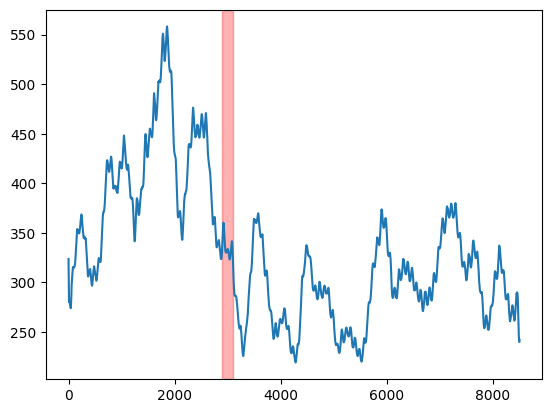

In [7]:
# predict anomaly scores
anomaly_scores = det.predict_anomaly_scores(testw)
anomaly_scores = reduce_window_scores(anomaly_scores, WINDOW_SIZE)
plt.plot(anomaly_scores)
plt.axvspan(anomaly_start-test_start, anomaly_end-test_start, color='red', alpha=0.3)


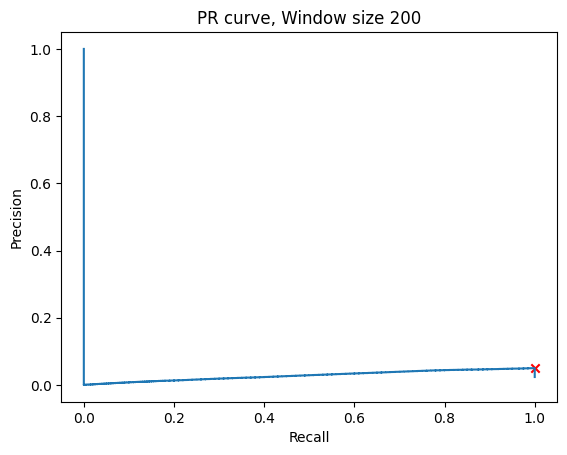

In [8]:


# Find best threshold according to best f1-score
p, r, t = precision_recall_curve(label, anomaly_scores)
f1 = 2*p*r / (p+r)
idx = np.nanargmax(f1)
PrecisionRecallDisplay(p, r).plot()
plt.scatter(r[idx], p[idx], marker='x', color='red', label='Best')
plt.title(f'PR curve, Window size {WINDOW_SIZE}')
best_t = t[idx]
best_f1 = f1[idx]


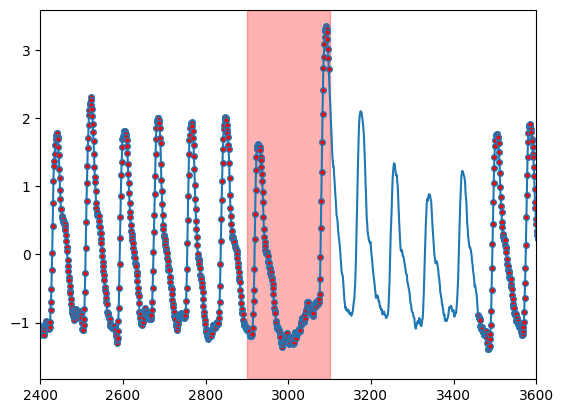

In [9]:

plt.plot(test[0], markevery=(anomaly_scores>best_t).reshape(-1).nonzero()[0], **dict(ms=4, marker='o', markerfacecolor='red'))
plt.xlim(anomaly_start-test_start - 500, anomaly_end-test_start + 500)
plt.axvspan(anomaly_start-test_start, anomaly_end-test_start, color='red', alpha=0.3)
plt.show()

# print(f'f1 {f1[idx]}')
# print(f'mv auc {mass_volume_auc_score(det, testw)}')
# print(f'sub mv auc {mv_feature_subsampling_auc_score(det, trainw, testw)}')